In [38]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import os

import helper_functions as helper

In [2]:
with open('data_path.txt', 'r') as f:
    data_path = os.path.join(f.readline(), 'steering')

file_path = os.path.join(data_path, 'MarkkulaEtAl_BiolCyb2018_DataWithIntermittentInterpretation.mat')
data = helper.loadmat(file_path)

lk_data = data['STasks'][0]
lk_subjects = np.arange(1, 16)

cd_data = data['STasks'][1]
cd_subjects = np.arange(1, 9)

# Prepare passive phase data

In [29]:
def get_passive_phase_data(data):
    passive_phases = []
    for i, driver in enumerate(data.SDrivers):
        for j, recording in enumerate(driver.SRecordings):
            # Option 1: steering wheel angular velocity from the original data
#             v = recording.SSignals.VSWRate

            # Option 2: VSWRate might be a bit oversmoothed, which might lead to underestimation of 
            # inter-adjustment intervals, so we try an alternative numerical differentiation algo here
            v = helper.differentiate(recording.SSignals.VTimeStamp, recording.SSignals.VSWAngle)
            
            # Also, here we'll try out a custom adjustment onset extraction algorithm I used for the stick data
            # It will miss adjustments initiated in the middle of preceding adjustment, but the thing
            # is, if we are to analyze inter-adjustment intervals, these are not well-defined here,
            # so I believe it's better to treat multi-movement corrections as a single adjustment
            starting_points, action_points = helper.extract_passive_phases(v)
            
            # Keeping the pre-calculated onset time here just in case
#            action_points = recording.SSteeringInterpretation.ViBurstStartSamples
#            action_points = np.array(action_points [~np.isnan(action_points)], dtype=int)            
#            starting_points = np.nan
#            eps_sp = np.nan
#            t_sp = np.nan
    
            eps_sp = recording.SSteeringInterpretation.VPredictedNeedForSteeringAdjustment[starting_points]
            eps_ap = recording.SSteeringInterpretation.VPredictedNeedForSteeringAdjustment[action_points]            
            t_sp = recording.SSignals.VTimeStamp[starting_points]
            t_ap = recording.SSignals.VTimeStamp[action_points]
            df = pd.DataFrame({'subject': i+1,
                               'recording': j+1,
                               'idx_sp': starting_points,
                               'idx_ap': action_points,
                               't_sp': t_sp, 
                               't_ap': t_ap,                               
                               'delta_t': t_ap-t_sp,
                               'eps_sp': eps_sp, 
                               'eps_ap': eps_ap})
            passive_phases.append(df)
            
    return pd.concat(passive_phases).set_index(['subject', 'recording'], drop=False)

def save_passive_phases_to_csv(data, task):
    passive_phases = get_passive_phase_data(data)
    passive_phases.to_csv(os.path.join(data_path, 'passive_phases_%s.csv' % (task)), index=False)

In [30]:
save_passive_phases_to_csv(lk_data, 'lk')
save_passive_phases_to_csv(cd_data, 'cd')

# Check passive phase data

In [31]:
passive_phases_lk = pd.read_csv(os.path.join(data_path, 'passive_phases_lk.csv'), index_col=None)
passive_phases_cd = pd.read_csv(os.path.join(data_path, 'passive_phases_cd.csv'), index_col=None)

In [32]:
print(len(passive_phases_lk), len(passive_phases_cd))

2276 592


C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


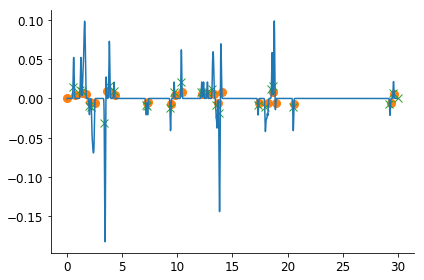

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


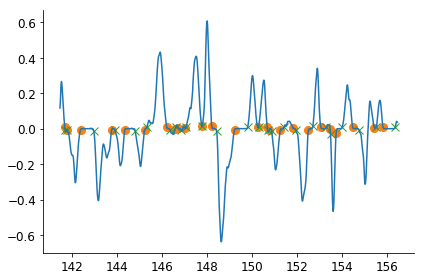

In [33]:
def plot_example_sw_rate(drivers, passive_phases):
    recording = drivers.SDrivers[0].SRecordings[0]
    t = recording.SSignals.VTimeStamp
    x = recording.SSignals.VSWAngle
#     v = helper.differentiate(t, x)
    
    v = recording.SSignals.VSWRate

    ap_idx = passive_phases[(passive_phases.subject==1) & (passive_phases.recording==1)].idx_ap.values
    sp_idx = passive_phases[(passive_phases.subject==1) & (passive_phases.recording==1)].idx_sp.values

    fig, ax = plt.subplots()    
    ax.plot(t[sp_idx], v[sp_idx], ls='', marker='o', ms=8, color='C1')
    ax.plot(t[ap_idx], v[ap_idx], ls='', marker='x', ms=8, color='C2')
    ax.plot(t, v)
#     ax.set_xlim([0,5])
    
plot_example_sw_rate(lk_data, passive_phases_lk)
plot_example_sw_rate(cd_data, passive_phases_cd)

# Exploring $\Delta_t$ distributions

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


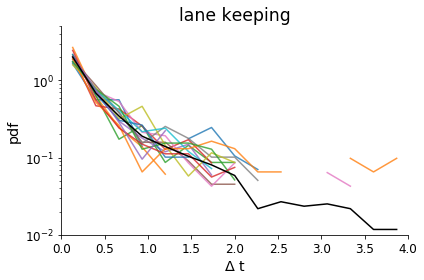

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


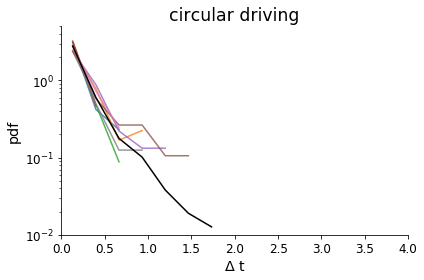

In [37]:
def plot_delta_t_hist(data, task):
    ax = helper.plot_pdf(data=data, var='delta_t', bins=np.linspace(0, 4, 16))
    ax.set_xlabel('$\Delta$ t')
    ax.set_ylabel('pdf')
    ax.set_xlim((0., 4))
    ax.set_ylim((0.01, 5))
    ax.set_title(task)
    
plot_delta_t_hist(passive_phases_lk, 'lane keeping')
plt.savefig('delta_t_pdf_lk.png')

plot_delta_t_hist(passive_phases_cd, 'circular driving')
plt.savefig('delta_t_pdf_cd.png')

# Look at $\epsilon$ distributions